In [3]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService


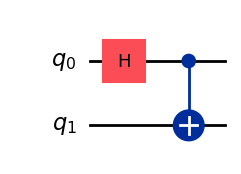

In [2]:
# 2 Q-bit curcuit
qc = QuantumCircuit(2)

# Hadamaard on first Qbit
qc.h(0)
# CNOT with control Qbit 0 and target Qbit 1
qc.cx(0,1)

qc.draw(output="mpl")

In [3]:
from qiskit.quantum_info import Pauli

ZZ = Pauli("ZZ")
ZI = Pauli("ZI")
IZ = Pauli("IZ")
IX = Pauli("IX")

observables = [ZZ, ZI, IZ, IX]


In [4]:
# Execute on the backend

from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        , -0.02929688, -0.00195312,  0.08984375]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000368541, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.000941042, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 16384, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'stabilizer', 'required_memory_mb': 0, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9991416931152344, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000356583, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_tak

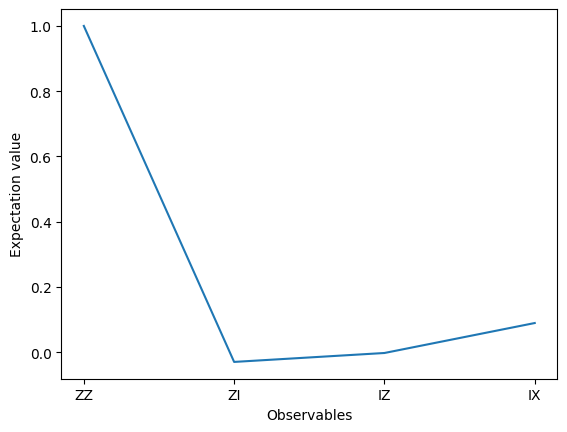

In [5]:
# post-process and plotting

import matplotlib.pyplot as plt

data = ["ZZ", "ZI", "IZ", "IX"]
values = job.result().values

plt.plot(data,values)
plt.xlabel("Observables")
plt.ylabel("Expectation value")
plt.show()

## Extend to n Qbit GHZ statw

### step 1: map the problem to curcuits and operators

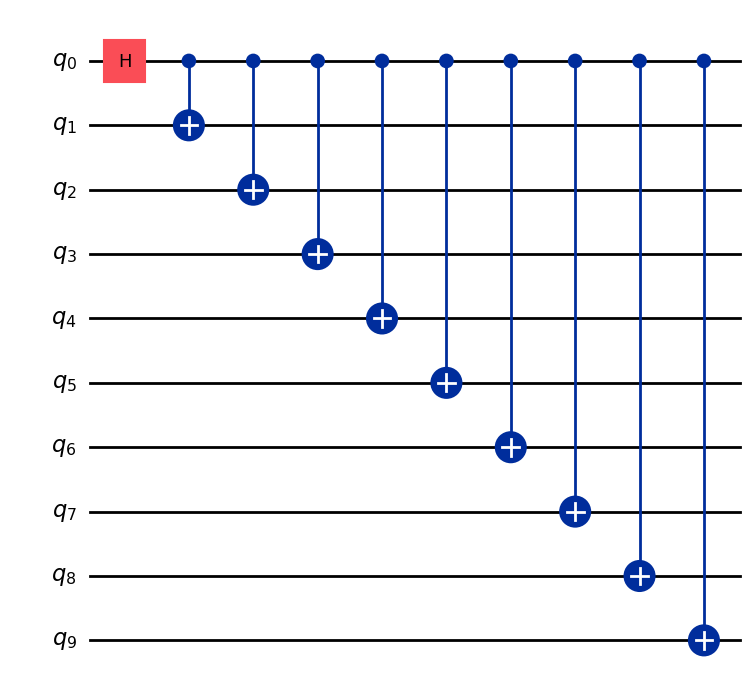

In [6]:
from qiskit.quantum_info import SparsePauliOp

n = 10
operator_strings = ["Z" + "I" * i + "Z" + "I" * (n-2-i) for i in range(n-1)]
#print(operator_strings)
operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]
#print(operators)

def get_qc_for_n_qbit_GHZ_states(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(0,i+1)
    return qc

qc = get_qc_for_n_qbit_GHZ_states(n)
qc.draw(output="mpl")


In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# fetch the backend
backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().backend(backend_name)

# create a pass manager, which will populate the method with 
# everything that needs to be know about the backend, e.g. connectivity,
# native gates
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

# transpile the code (source code to source code)
qc_transpiled = pass_manager.run(qc)
# when mapping the quantum curcuit to a device, the order gets swapped around
# the apply_layout method will make sure that the correct operator till applied to
# the right points on the transpiled curcuit. 
operatorns_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

KeyboardInterrupt: 

### step 3: execute on the backend

In [ ]:
# v2 makes results more intuitive
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
# level 1 = use measurement readout mitigation, level 2 = zero noise extrapolation, ... 
options.resilience_level = 1
# transpolation already done on local device
options.optimization_level = 0
# qc has a lot idle time, use dynamic coupling
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# generate estimator object with options
estimator = Estimator(backend, options)

# run job with transpiled qc and opterator list
job = estimator.run([(qc_transpiled, operatorns_transpiled_list)])
job_id = job.job_id()
print(job_id)


/var/folders/2c/txnynyhs64n9vglhwrc4k0z40000gq/T/ipykernel_67098/2966108972.py:15: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(backend, options)


ctecs14akxxg008mzabg


## step 4: post-process and plot

In [7]:
job_id = "ctecs14akxxg008mzabg"
# retreive the job
service = QiskitRuntimeService()
job = service.job(job_id)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
<generator object <genexpr> at 0x15b3d15b0>


RuntimeError: matplotlib does not support generators as input

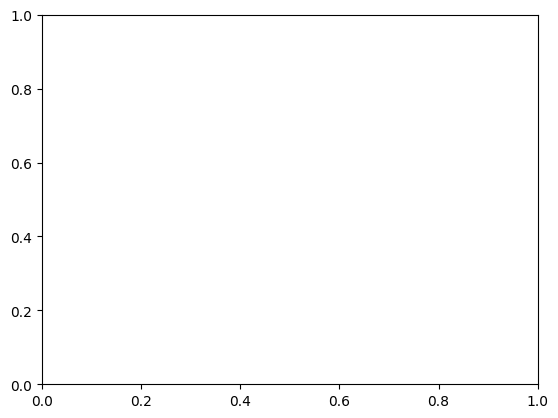

In [9]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = (v / values[0] for v in values)

print(data)
print(values)

plt.scatter(data, values, marker='o', label="10 Qbit GHZ state")
#plt.xlabel("Distance between Qbits $i$")
#plt.ylabel(r"\langle Z_0 Z_i \rangle  / \langle Z_0 Z_1 \rangle$")